<a href="https://colab.research.google.com/github/Badugujoshna/data-science-project/blob/main/sms_spam_ham_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Data Collection

In [ ]:
data_path = "/content/drive/Shareddrives/CS418/final project/data/SMSSpamCollection"
data = pd.read_csv(data_path,delimiter="\t",header=None)
data.columns = ["class","message"]

In [ ]:
data.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.shape

(5572, 2)

In [ ]:
data['class'].value_counts()

ham     4825
spam     747
Name: class, dtype: int64

## Data Preparation/Text Analysis

In [ ]:
def spell_corrected(msg):
  spell = SpellChecker()

  # find those words that may be misspelled
  misspelled = spell.unknown(msg)
  corrected_words = {}
  for word in misspelled:
      # Get the one `most likely` answer
      correct_spell = spell.correction(word)
      if correct_spell != word:
          corrected_words[word] = correct_spell

  for m in range(len(msg)):
    try:
      msg[m] = corrected_words[msg[m]]
    except:
      pass
  return msg

In [19]:
corpus_stemmed = []
corupus_not_stemmed = []

ps = PorterStemmer()

for i in range(len(data['message'])):
# for i in range(0,len (test)):
    # Applying Regular Expression

    '''
    Replace email addresses with 'emailaddr'
    Replace URLs with 'httpaddr'
    Replace money symbols with 'moneysymb'
    Replace phone numbers with 'phonenumbr'
    Replace numbers with 'numbr'
    '''
    if i %100 == 0:
      print(i)
    # msg = test[i]
    msg = data['message'][i]
    # Each word to lower case
    msg = msg.lower()
    # print(msg)
    msg = re.sub('[\w\-.]+?@\w+?\.\w{2,4}', ' emailaddr ', msg)
    msg = re.sub('(http[s]?\S+)|(\w+\.[a-z]{2,4}\S*)', 'httpaddr', msg)
    msg = re.sub('£|\$', ' moneysymb ', msg)
    msg = re.sub(' [0-9]{4}(-)?[0-9]{3}(-)?[0-9]{4} ', ' phonenumber ', msg)
    msg = re.sub('\d+(\.\d+)?', ' number ', msg)
    msg = re.sub(' u ', ' you ', msg)

    ''' Remove all punctuations '''
    msg = re.sub('[^\w\d\s]', ' ', msg)
    # Splitting words to Tokenize
    msg = msg.split()
    # print(msg)
    msg = spell_corrected(msg)
    corupus_not_stemmed.append(' '.join(msg))
    # print(msg)
    # Stemming with PorterStemmer handling Stop Words
    msg = [ps.stem(word) for word in msg if not word in set(stopwords.words('english'))]

    # # preparing Messages with Remaining Tokens
    msg = ' '.join(msg)
    # print(msg)
    # Preparing WordVector Corpus
    corpus_stemmed.append(msg)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500


In [22]:
data['not_stemmed'] = corupus_not_stemmed

In [23]:
data['stemmed'] = corpus_stemmed

In [24]:
data.to_csv("/content/data_cleaned.csv",sep=";")

In [26]:
data_path = "/content/data_cleaned.csv"
data = pd.read_csv(data_path,delimiter=";",index_col=None)
data = data.iloc[:, 1:]

In [ ]:
data.head()

,class,message,not_stemmed,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...",go until juron point crazy available only in b...,go juron point crazi avail bugi n great world ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking if you on,ok lar joke
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in number a wily comp to win fa cup...,free entri number wili comp win fa cup final t...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor you c already then say,u dun say earli hor c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to us he lives aroun...,nah think goe us live around though


In [27]:
data['stemmed'] = data['stemmed'].fillna("")
data['not_stemmed'] = data['not_stemmed'].fillna("")

## Data Exploration

In [28]:
token_length_stemmed = []
for d in data['stemmed']:
  token_length_stemmed.append(len(d.split()))

In [29]:
token_length_not_stemmed = []
for d in data['not_stemmed']:
  token_length_not_stemmed.append(len(d.split()))

In [30]:
character_length_stemmed = []
for d in data['stemmed']:
  character_length_stemmed.append(len(d))

In [31]:
character_length_not_stemmed = []
for d in data['not_stemmed']:
  character_length_not_stemmed.append(len(d))

In [32]:
data['tokens_stemmed'] = token_length_stemmed
data['characters_stemmed'] = character_length_stemmed
data['tokens_not_stemmed'] = token_length_not_stemmed
data['characters_not_stemmed'] = character_length_not_stemmed

In [36]:
# Select only the numeric columns before calculating the mean
y_graph = data.groupby('class')[['tokens_stemmed', 'characters_stemmed', 'tokens_not_stemmed', 'characters_not_stemmed']].mean()

<Axes: title={'center': 'Average number of tokens(stemmed) in each class'}, ylabel='tokens_stemmed'>

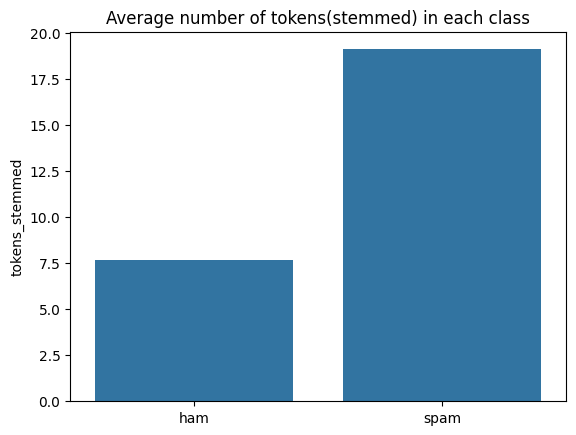

In [40]:
plt.title("Average number of tokens(stemmed) in each class")
sns.barplot(x=['ham','spam'],y='tokens_stemmed', data=y_graph)

<Axes: title={'center': 'Average number of tokens(not stemmed) in each class'}, ylabel='tokens_not_stemmed'>

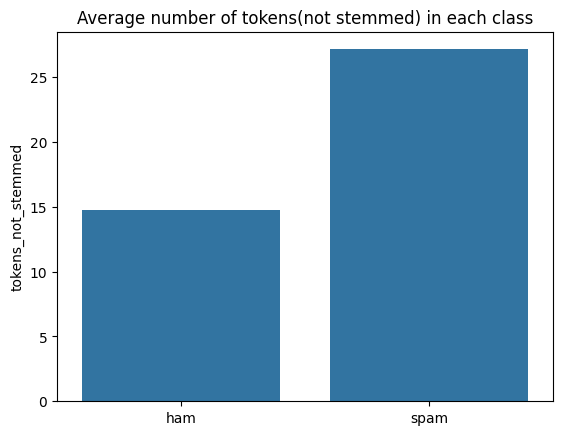

In [41]:
plt.title("Average number of tokens(not stemmed) in each class")
sns.barplot(x=['ham','spam'],y='tokens_not_stemmed', data=y_graph)

<Axes: title={'center': 'Average character lenght(stemmed) in each class'}, ylabel='characters_stemmed'>

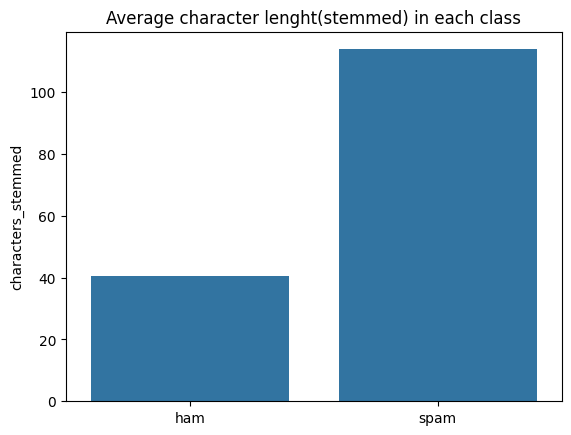

In [42]:
plt.title("Average character lenght(stemmed) in each class")
sns.barplot(x=['ham','spam'],y='characters_stemmed', data=y_graph)

<Axes: title={'center': 'Average character lenght(not stemmed) in each class'}, ylabel='characters_not_stemmed'>

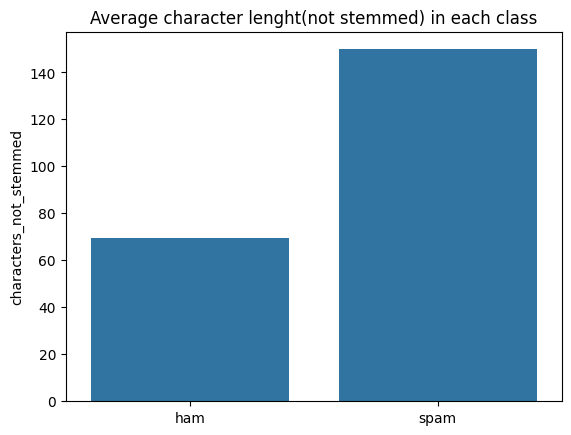

In [43]:
plt.title("Average character lenght(not stemmed) in each class")
sns.barplot(x=['ham','spam'],y='characters_not_stemmed', data=y_graph)

In [44]:
data_spam = data[data['class']=='spam']

In [45]:
words = " ".join(data_spam.stemmed).split()

words_score ={word:0 for word in words}
# with white background --- for top 1000 words (tf-idf)in the dictionary
for each_word in list(set(words)):
    try:
      words_score[each_word] += words.count(each_word)
    except:
      pass

==== top 100 by occurences for spam ====


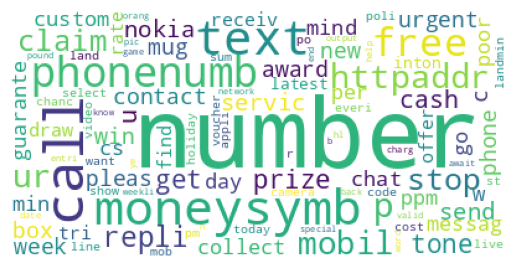

In [46]:
print ("==== top 100 by occurences for spam ====")
wc = WordCloud(
    background_color="white",
    max_words=100
)

ww = wc.fit_words(words_score)
plt.imshow(ww)
plt.axis("off")
plt.show()

In [47]:
data_ham = data[data['class']=='ham']

In [48]:
words = " ".join(data_ham.stemmed).split()

words_score ={word:0 for word in words}
# with white background --- for top 1000 words (tf-idf)in the dictionary
for each_word in list(set(words)):
    try:
      words_score[each_word] += words.count(each_word)
    except:
      pass

==== top 100 by occurences for ham =====


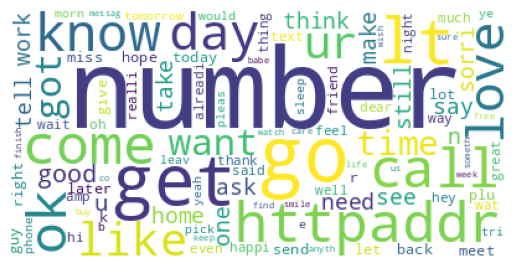

In [49]:
print ("==== top 100 by occurences for ham =====")
wc = WordCloud(
    background_color="white",
    max_words=100
)

ww = wc.fit_words(words_score)
plt.imshow(ww)
plt.axis("off")
plt.show()

## Classification - CountVectorizer


In [50]:
y = data.replace(['ham','spam'],[0, 1])['class']

/tmp/ipython-input-2773579653.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data.replace(['ham','spam'],[0, 1])['class']


In [51]:
y.value_counts()

,count
class,
0,4825
1,747


In [52]:
cv = CountVectorizer()
x = cv.fit_transform(data['stemmed']).toarray()

In [53]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y,test_size= 0.30, random_state = 0)

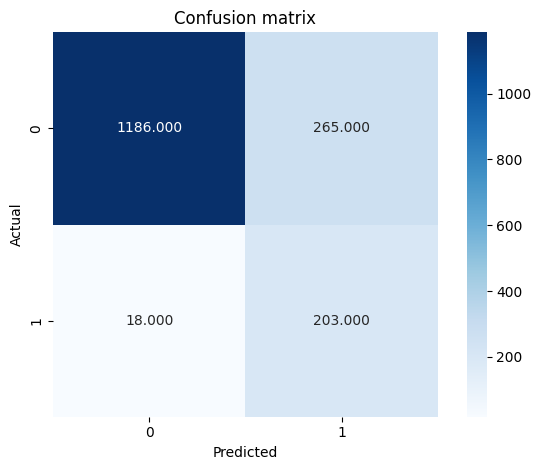

In [54]:
classifier = GaussianNB()
classifier.fit(xtrain, ytrain)

y_pred = classifier.predict(xtest)

conf_matrix = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [55]:
accuracy = metrics.accuracy_score(ytest, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(ytest, y_pred, average=None)
recall = metrics.recall_score(ytest, y_pred, average=None)
F1_score = metrics.f1_score(ytest, y_pred, average=None)
print([accuracy, error, precision, recall, F1_score])

[0.8307416267942583, 0.16925837320574166, array([0.98504983, 0.43376068]), array([0.81736733, 0.91855204]), array([0.89340866, 0.5892598 ])]


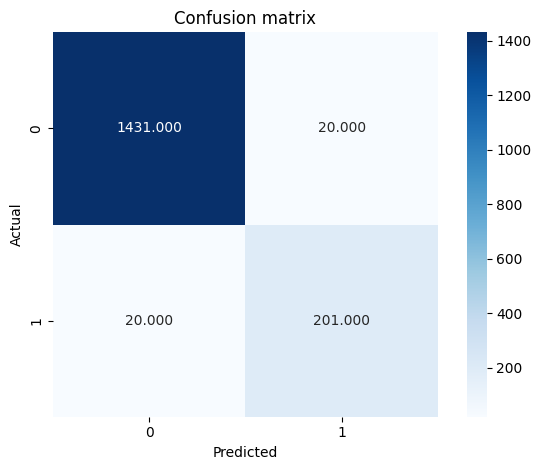

In [56]:
classifier = DecisionTreeClassifier(random_state=0, criterion='entropy')
classifier.fit(xtrain, ytrain)

y_pred = classifier.predict(xtest)

conf_matrix = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [57]:
accuracy = metrics.accuracy_score(ytest, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(ytest, y_pred, average=None)
recall = metrics.recall_score(ytest, y_pred, average=None)
F1_score = metrics.f1_score(ytest, y_pred, average=None)
print([accuracy, error, precision, recall, F1_score])

[0.9760765550239234, 0.02392344497607657, array([0.9862164 , 0.90950226]), array([0.9862164 , 0.90950226]), array([0.9862164 , 0.90950226])]


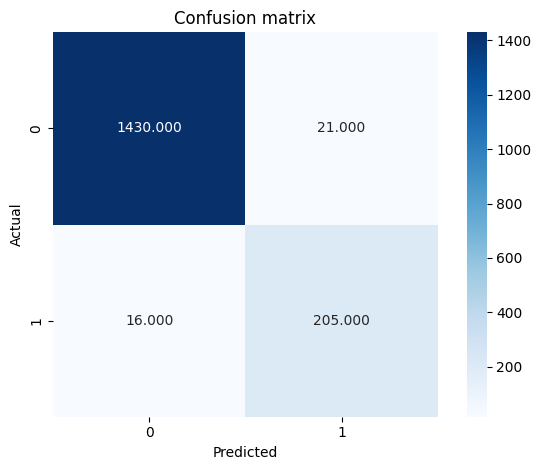

In [58]:
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(xtrain, ytrain)

y_pred = classifier.predict(xtest)

conf_matrix = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [59]:
accuracy = metrics.accuracy_score(ytest, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(ytest, y_pred, average=None)
recall = metrics.recall_score(ytest, y_pred, average=None)
F1_score = metrics.f1_score(ytest, y_pred, average=None)
print([accuracy, error, precision, recall, F1_score])

[0.9778708133971292, 0.022129186602870776, array([0.98893499, 0.90707965]), array([0.98552722, 0.92760181]), array([0.98722817, 0.91722595])]


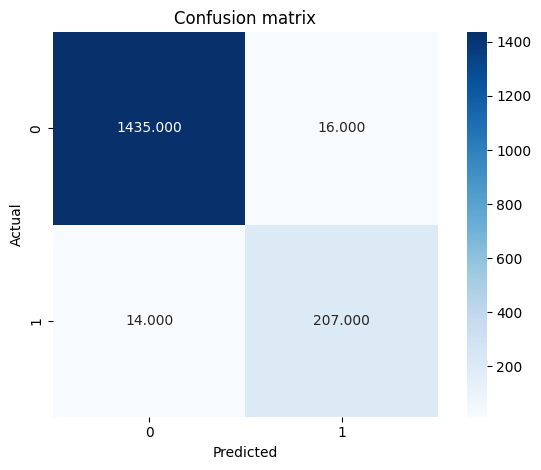

In [60]:
classifier = SVC(kernel = 'linear')
classifier.fit(xtrain, ytrain)

y_pred = classifier.predict(xtest)

conf_matrix = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [ ]:
accuracy = metrics.accuracy_score(ytest, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(ytest, y_pred, average=None)
recall = metrics.recall_score(ytest, y_pred, average=None)
F1_score = metrics.f1_score(ytest, y_pred, average=None)
print([accuracy, error, precision, recall, F1_score])

[0.9838516746411483, 0.01614832535885169, array([0.99103448, 0.93693694]), array([0.99035148, 0.94117647]), array([0.99069286, 0.93905192])]


## Classification TFIDF

In [61]:
vec = TfidfVectorizer()
x = vec.fit_transform(data['stemmed']).toarray()

In [62]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y,test_size= 0.30, random_state = 0)

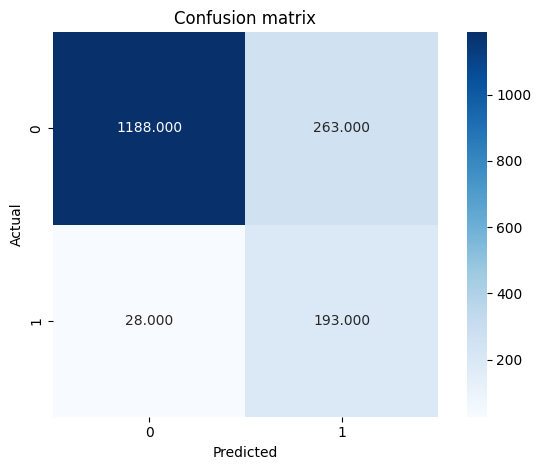

In [63]:
classifier = GaussianNB()
classifier.fit(xtrain, ytrain)

y_pred = classifier.predict(xtest)

conf_matrix = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [64]:
accuracy = metrics.accuracy_score(ytest, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(ytest, y_pred, average=None)
recall = metrics.recall_score(ytest, y_pred, average=None)
F1_score = metrics.f1_score(ytest, y_pred, average=None)
print([accuracy, error, precision, recall, F1_score])

[0.8259569377990431, 0.1740430622009569, array([0.97697368, 0.42324561]), array([0.81874569, 0.87330317]), array([0.89088864, 0.57016248])]


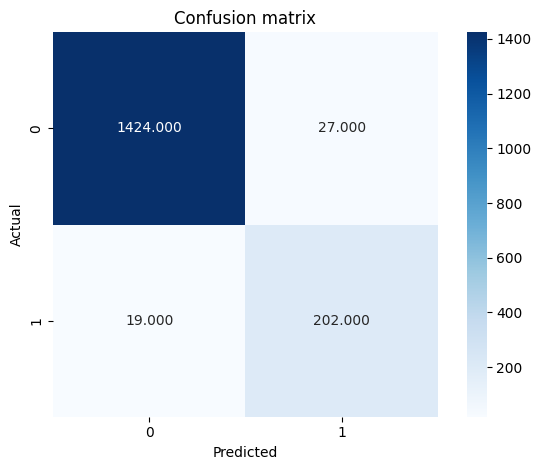

In [65]:
classifier = DecisionTreeClassifier(random_state=0, criterion='entropy')
classifier.fit(xtrain, ytrain)

y_pred = classifier.predict(xtest)

conf_matrix = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [66]:
accuracy = metrics.accuracy_score(ytest, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(ytest, y_pred, average=None)
recall = metrics.recall_score(ytest, y_pred, average=None)
F1_score = metrics.f1_score(ytest, y_pred, average=None)
print([accuracy, error, precision, recall, F1_score])

[0.972488038277512, 0.027511961722488043, array([0.98683299, 0.88209607]), array([0.98139214, 0.91402715]), array([0.98410504, 0.89777778])]


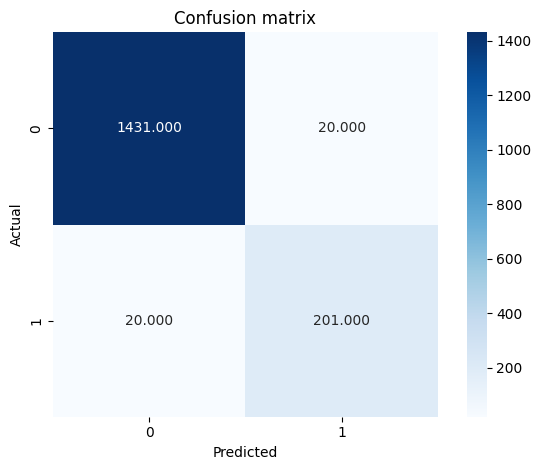

In [67]:
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(xtrain, ytrain)

y_pred = classifier.predict(xtest)

conf_matrix = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [68]:
accuracy = metrics.accuracy_score(ytest, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(ytest, y_pred, average=None)
recall = metrics.recall_score(ytest, y_pred, average=None)
F1_score = metrics.f1_score(ytest, y_pred, average=None)
print([accuracy, error, precision, recall, F1_score])

[0.9760765550239234, 0.02392344497607657, array([0.9862164 , 0.90950226]), array([0.9862164 , 0.90950226]), array([0.9862164 , 0.90950226])]


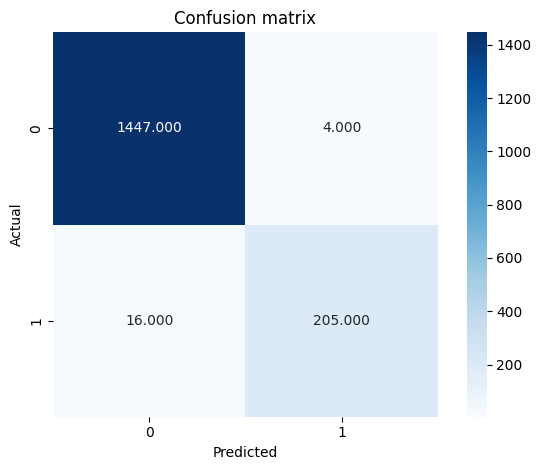

In [69]:
classifier = SVC(kernel = 'linear')
classifier.fit(xtrain, ytrain)

y_pred = classifier.predict(xtest)

conf_matrix = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [70]:
accuracy = metrics.accuracy_score(ytest, y_pred)
error = 1 - accuracy
precision = metrics.precision_score(ytest, y_pred, average=None)
recall = metrics.recall_score(ytest, y_pred, average=None)
F1_score = metrics.f1_score(ytest, y_pred, average=None)
print([accuracy, error, precision, recall, F1_score])

[0.9880382775119617, 0.011961722488038284, array([0.98906357, 0.98086124]), array([0.99724328, 0.92760181]), array([0.99313658, 0.95348837])]
